### Import essential packages

In [1]:
import glob
import random
import re
import nltk
from stemming.porter2 import stem
from nltk.corpus import stopwords
import string
import numpy as np
import pandas as pd
import csv
import networkx as nx
from matplotlib import pylab
from matplotlib import pyplot as plt
import scipy.sparse

### Import amazon co-purchased products meta data file

In [24]:
# Loading the datafile
filename="amazon-meta.txt"
text = open(filename,'r',encoding='utf-8',errors='ignore')

### Data Preprocessing

In [25]:
# Initialize a dictionary to store Amazon product information
products = {}

# Define a tuple to hold product attributes
(attributes, product_id, product_title, category_list, product_group, related_products, ranking, review_count, average_rating, centrality_score, clustering_value) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)

# Process each line in the provided text data
for line in text:
    line = line.strip()

    # Extract various product attributes from the text
    if line.startswith("Id"):
        product_id = line[3:].strip()
    elif line.startswith("ASIN"):
        attributes = line[5:].strip()
    elif line.startswith("title"):
        product_title = ' '.join(line[6:].strip().split())
    elif line.startswith("group"):
        product_group = line[6:].strip()
    elif line.startswith("salesrank"):
        ranking = line[10:].strip()
    elif line.startswith("similar"):
        related_products = ' '.join(line.split()[2:])
    elif line.startswith("categories"):
        num_categories = int(line.split()[1].strip())
        category_list = ' '.join((text.readline()).lower() for _ in range(num_categories))
        category_list = re.sub('[%s]' % re.escape(string.digits + string.punctuation), ' ', category_list)
        category_list = ' '.join(set(category_list.split()) - set(stopwords.words('english')))
        category_list = ' '.join(stem(word) for word in category_list.split())
    elif line.startswith("reviews"):
        review_data = line.split()
        review_count = review_data[2].strip()
        average_rating = review_data[7].strip()
    elif line == "":
        try:
            if attributes:
                product_entry = {
                    'Id': product_id,
                    'title': product_title,
                    'group': product_group,
                    'categories': ' '.join(set(category_list.split())),
                    'connections': related_products,
                    'salesrank': int(ranking),
                    'tot_reviews': int(review_count),
                    'avg_rating': float(average_rating),
                    'degree_centrality': centrality_score,
                    'clustering_coeff': clustering_value
                }
                products[attributes] = product_entry
        except NameError:
            continue
        # Reset the tuple for the next product entry
        (attributes, product_id, product_title, category_list, product_group, related_products, ranking, review_count, average_rating, centrality_score, clustering_value) = ("", "", "", "", "", "", 0, 0, 0.0, 0, 0.0)

# Close the text data source
text.close()

In [4]:
# Subset of music products in the dataset 
amazon_music = {key: value for key, value in products.items() if value['group'] == "Music"}

# Update connections to include only those within the amazon_music subset
for product in amazon_music.values():
    product['connections'] = ' '.join([conn for conn in product['connections'].split() if conn in amazon_music])

# Convert to dataframe without needing to transpose
amazon_music_df = pd.DataFrame.from_dict(amazon_music, orient='index')

In [5]:
len(amazon_music_df)

103144

In [6]:
# Creating a subset of book products in the dataset 
amazon_books = {key: value for key, value in products.items() if value['group'] == "Book"}

# Update connections to include only those within the amazon_books subset
for product in amazon_books.values():
    product['connections'] = ' '.join([conn for conn in product['connections'].split() if conn in amazon_books])

# Convert the subset dictionary to a DataFrame
amazon_books_df = pd.DataFrame.from_dict(amazon_books, orient='index')

In [7]:
len(amazon_books_df)

393561

In [8]:
# Creating a subset of dvd products in the dataset 
amazon_dvd = {key: value for key, value in products.items() if value['group'] == "DVD"}

# Update connections to include only those within the amazon_books subset
for product in amazon_dvd.values():
    product['connections'] = ' '.join([conn for conn in product['connections'].split() if conn in amazon_dvd])

# Convert the subset dictionary to a DataFrame
amazon_dvd_df = pd.DataFrame.from_dict(amazon_dvd, orient='index')

In [9]:
len(amazon_dvd_df)

19828

In [10]:
# Creating a subset of dvd products in the dataset 
amazon_video = {key: value for key, value in products.items() if value['group'] == "Video"}

# Update connections to include only those within the amazon_books subset
for product in amazon_video.values():
    product['connections'] = ' '.join([conn for conn in product['connections'].split() if conn in amazon_video])

# Convert the subset dictionary to a DataFrame
amazon_video_df = pd.DataFrame.from_dict(amazon_dvd, orient='index')

In [11]:
len(amazon_video_df)

19828

### Similarity between two connected nodes

In [26]:

# Constructing a graph to represent the connections between nodes
nodes_graph = nx.Graph()

# Iterating through amazon dictionary to build the graph
for product_id, product_info in products.items():
    # Adding each product as a node in the graph
    nodes_graph.add_node(product_id)

    # Iterating through connected products
    for connected_id in product_info['connections'].split():
        # Add connected products as nodes
        nodes_graph.add_node(connected_id.strip())
        # Initialize similarity score
        similarity_score = 0

        try:
            # Extracting category sets for comparison
            category_set_product = set(products[product_id]['categories'].split())
            category_set_connected = set(products[connected_id]['categories'].split())
        except KeyError:
            # Skip if there's a KeyError
            continue

        # Perform set operations for similarity calculation
        intersection_set = category_set_product & category_set_connected
        union_set = category_set_product | category_set_connected

        # Calculate similarity score based on set intersection and union
        if len(intersection_set) > 0:
            similarity_score = round(len(intersection_set) / len(union_set), 2)

        # Adding an edge between nodes with the similarity score as weight
        nodes_graph.add_edge(product_id, connected_id.strip(), weight=similarity_score)


In [29]:
#Adjacency matrix
A=nx.adjacency_matrix(nodes_graph)

In [30]:
# Laplacian matrix
L = nx.laplacian_matrix(nodes_graph)

In [31]:
# Importing necessary function from scipy
from scipy.sparse.linalg import eigsh

# Adjusted to handle large datasets, focusing on the 250 most significant eigenvalues/eigenvectors
top_eigenvalues, top_eigenvectors = eigsh(L, k=250, which='LM', return_eigenvectors=True)


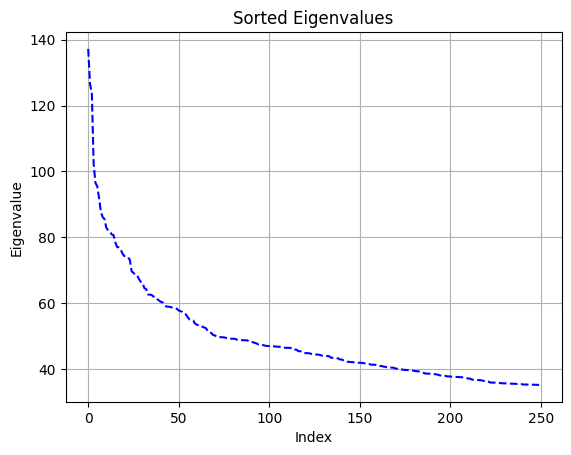

In [180]:
# Arrange the indices of eigenvalues in descending order
sorted_indices = np.argsort(top_eigenvalues)[::-1]

# Reorder the eigenvalues using the sorted indices
sorted_eigenvalues = top_eigenvalues[sorted_indices]

# Plot the sorted eigenvalues with modifications
plt.plot(sorted_eigenvalues, color='blue', linestyle='--')  # Change color and line style
plt.title('Sorted Eigenvalues')  # Add a title
plt.xlabel('Index')  # Add x-axis label
plt.ylabel('Eigenvalue')  # Add y-axis label
plt.grid(True)  # Add a grid for better readability
plt.show()

# Align the eigenvectors with the sorted eigenvalues
sorted_eigenvectors = top_eigenvectors[:, sorted_indices]


In [41]:
import sklearn
from sklearn.cluster import KMeans

# Extracting the top 50 eigenvectors for dimensionality reduction
reduced_eigenvectors = top_eigenvectors[:, :50]

# Performing K-means clustering to divide the data into 4 distinct clusters
k_means = KMeans(n_clusters=4)
k_means.fit(reduced_eigenvectors)
cluster_labels = k_means.labels_


c:\Users\srush\Desktop\1 semester\IE 532\532 PROJECT\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [42]:
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [43]:
# Computing node metrics in the network graph
degree_centrality = nx.degree(nodes_graph)
for node in nodes_graph.nodes():
    if node not in products:
        continue
    product_info = products[node]

    # Assigning the degree centrality to the product
    product_info['degree_centrality'] = int(degree_centrality[node])

    # Calculating the ego graph for the node
    ego_net = nx.ego_graph(nodes_graph, node, radius=1)

    # Determining the clustering coefficient for the node
    product_info['clustering_coeff'] = round(nx.average_clustering(ego_net), 2)

    # Updating the amazon dictionary
    products[node] = product_info

# Displaying edge weights for a subset of edges
edge_count = 0
for from_node, to_node, edge_data in nodes_graph.edges(data=True):
    if edge_count == 150:
        break
    print(edge_data['weight'])
    edge_count += 1

0.7
0.5
0.8
0.8
0.7
0.7
0.7
0.7
0.7
0.75
1.0
0.9
0.78
0.39
0.5
0.39
0.6
0.33
0.78
1.0
0.45
0.9
1.0
0.78
0.64
0.7
0.78
0.9
0.9
0.64
0.6
0.78
0.64
0.64
0.44
0.78
1.0
1.0
0.5
0.4
0.23
0.28
0.44
0.44
0.47
0.47
0.26
0.39
0.44
0.39
0.68
0.94
0.44
0.21
0.33
0.44
0.14
0.33
0.39
0.32
0.39
0.44
0.83
0.8
0.58
0.1
0.8
1.0
0.7
0.7
0.58
0.7
0.28
0.62
0.47
0.9
0.9
0.42
0.58
0.58
0.7
0.69
0.46
0.47
0.43
0.64
0.57
0.35
0.53
0.5
0.73
0.31
0.17
0.4
0.57
0.42
0.88
0.88
1.0
0.79
0.1
0.87
0.48
0.81
0.71
0.75
0.19
0.1
0.34
0.39
0.41
0.48
0.48
0.39
0.42
0.48
0.16
0.32
0.31
0.42
0.26
0.94
0.73
0.81
0.59
0.45
0.25
0.69
0.88
0.76
0.63
0.88
0.85
0.69
0.55
0.36
0.79
1.0
0.9
0.9
0.9
0.9
0.9
0.56
0.62
0.9
0.9
0.9
0.86
0.9


In [44]:
# Saving the edgelist
writer = open('amazon_edgelist.txt','w',encoding='utf-8',errors='ignore')
writer.write("Id\t" + "ASIN\t" + "title\t" + "group\t" + "categories\t" + "connections\t" + "salesrank\t" + "tot_reviews\t" + "avg_rating\t" + "degree_centrality\t" + "clustering_coeff\n")
for key, value in products.items():
  writer.write(value['Id']+"\t"+key+"\t"+value['title']+"\t"+value["group"]+"\t"+value["categories"]+"\t"+value["connections"]+"\t"+str(value["salesrank"])+"\t"+str(value["tot_reviews"])+"\t"+str(value["avg_rating"])+"\t"+str(value["degree_centrality"])+"\t"+str(value["clustering_coeff"]))

writer.close()

In [47]:
# Saving the edgelist's associated graph
writer = open("amazon_edgelist","wb")
nx.write_weighted_edgelist(nodes_graph, writer)

In [48]:
items = list(products.items())

In [49]:
# Converting the dictionary into a dataframe
ls = []
for i, j in enumerate(items):
    colnames = list(j[1])
    colnames.append("ASIN")
    vals = list(j[1].values())
    vals.append(j[0])
    ls.append(vals)
df = pd.DataFrame(ls, columns=colnames)

### Regression models

In [50]:
# Choosing salesrank, total reviews, average rating, degree centrality, and clustering coefficient columns
# df.head()
df_new = df[["salesrank","tot_reviews","avg_rating","degree_centrality","clustering_coeff"]]
for i in range(len(df_new['salesrank'])):
    if df_new['salesrank'][i] == 0:
        df_new = df_new.drop(i)
df_new.head()

,salesrank,tot_reviews,avg_rating,degree_centrality,clustering_coeff
1,396585,2,5.0,8,0.80
2,168596,12,4.5,9,0.85
3,1270652,1,5.0,0,0.00
4,631289,1,4.0,6,0.79
5,455160,0,0.0,4,1.00


In [51]:
clustering_coeff_sorted = df.sort_values('clustering_coeff', ascending=False)

In [52]:
print(clustering_coeff_sorted[['title','group']][0:10])

                                                    title  group
459865  Hot As Ice (Code Name: Danger) (Silhouette Int...   Book
151652  Success With Heart Failure: Help and Hope for ...   Book
476184  The Miniature Pinscher : An Owner's Guide to a...   Book
150896                              The Big Book of Logos   Book
476190           Core Servlets and JavaServer Pages (JSP)   Book
150889                               Music for the Maases  Music
476193                         Play Cribbage to Win MENSA   Book
150880  Faith No More - Who Cares A Lot? The Greatest ...  Music
150872                              Sings Ennio Morricone  Music
476199                    Cymbeline (Pelican Shakespeare)   Book


In [53]:
degree_centrality_sorted = df.sort_values('degree_centrality', ascending=False)

In [54]:
print(degree_centrality_sorted[["title",'group']][0:10])

                                                    title group
548091                                              Laura   DVD
458358  Diagnostic and Statistical Manual of Mental Di...  Book
222074  Publication Manual of the American Psychologic...  Book
199628                                   The Great Gatsby  Book
515301  1001 Most Useful Spanish Words (Beginners' Gui...  Book
291117                                           It Works  Book
502784           Brown Bear, Brown Bear, What Do You See?  Book
296016  Easy Spanish Phrase Book: Over 770 Basic Phras...  Book
239107                                         The Prince  Book
436020                                        The TEMPEST  Book


In [55]:
# Train test split
train, test = df_new.sample(frac=0.6), df_new.sample(frac=0.4) 

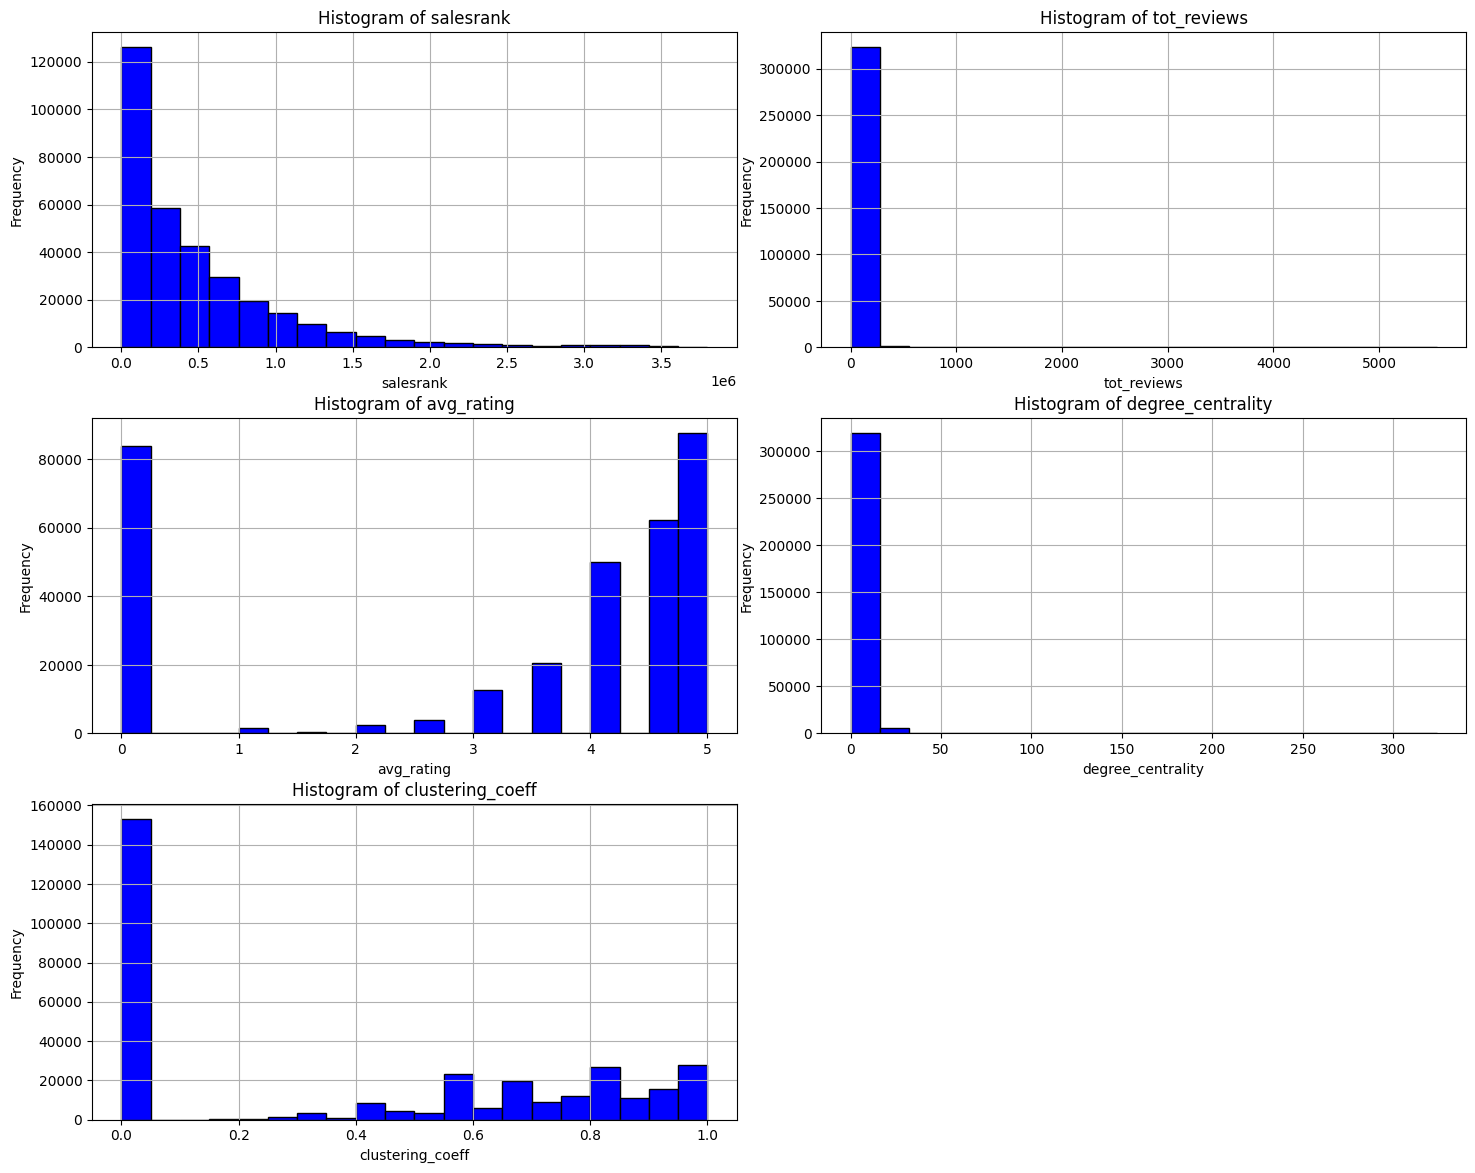

In [182]:
num_columns = train.shape[1]
num_rows = (num_columns + 1) // 2  

# Set up the subplot grid
fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 4))  
fig.tight_layout(pad=3.0)  

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each column and create a histogram
for i, column in enumerate(train.columns):
    ax = axes[i]
    ax.hist(train[column], bins=20, color='blue', edgecolor='black')  
    ax.set_title(f'Histogram of {column}', fontsize=12) 
    ax.set_xlabel(column)  
    ax.set_ylabel('Frequency')  
    ax.grid(True)  
# Turn off any unused subplots
for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

plt.show()

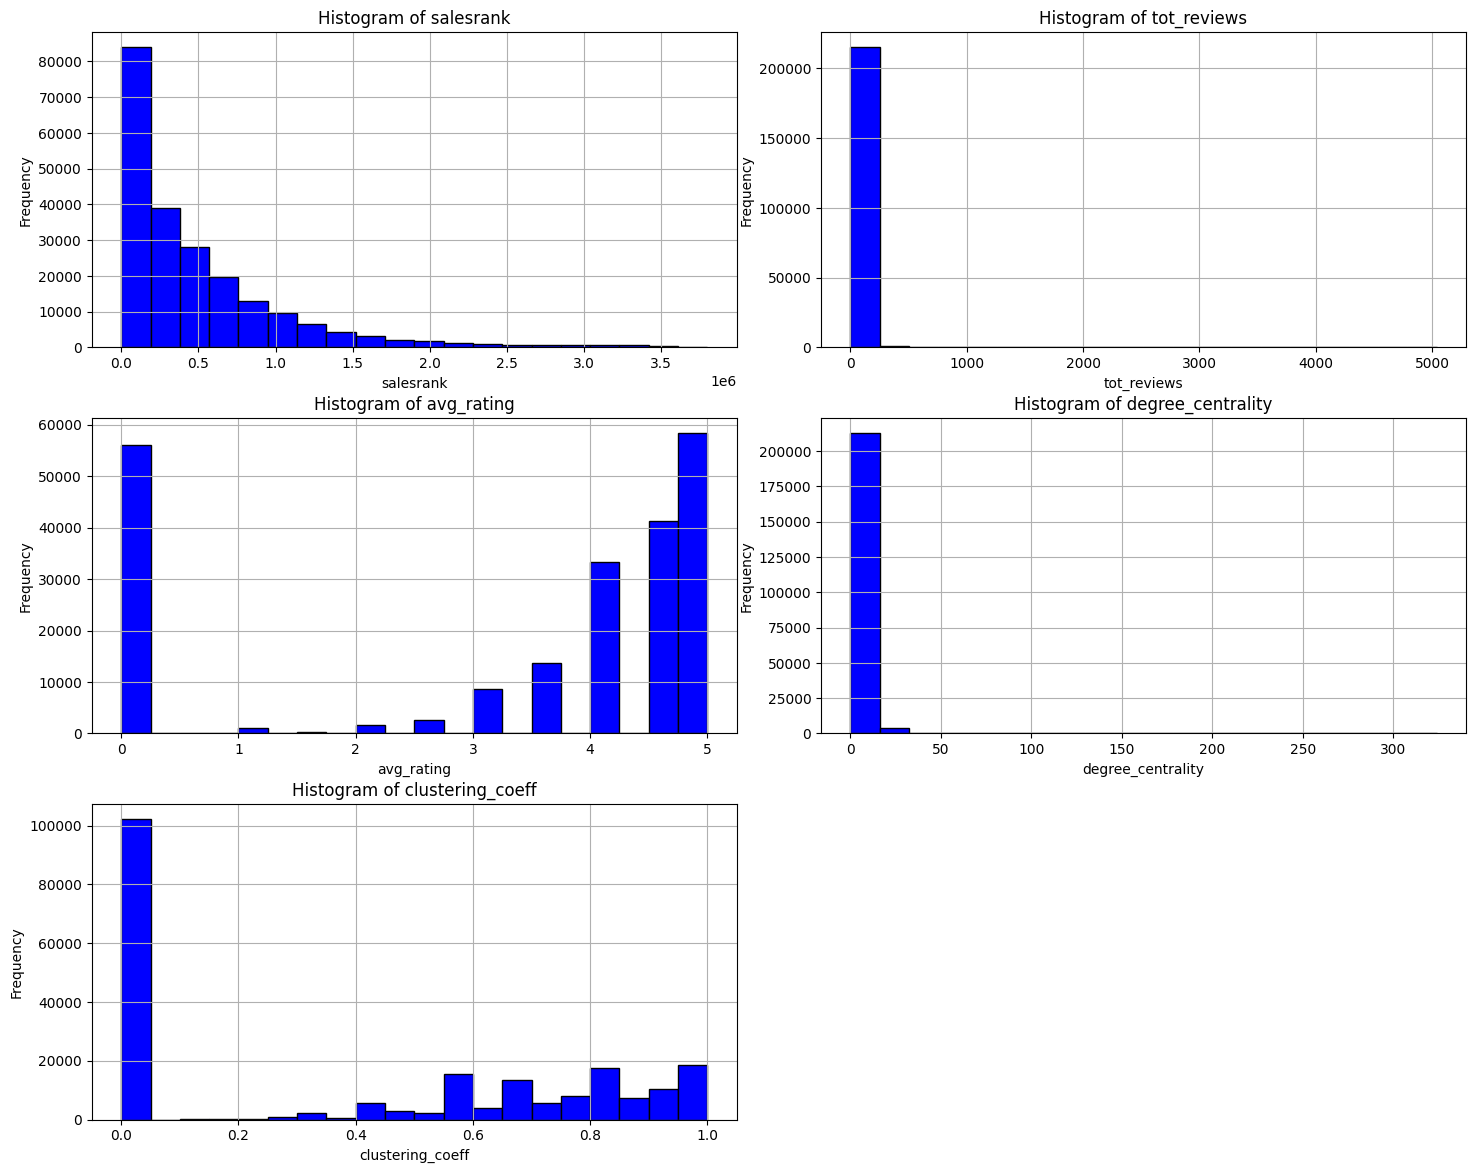

In [183]:
num_columns = test.shape[1]
num_rows = (num_columns + 1) // 2  

# Set up the subplot grid
fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 4))  
fig.tight_layout(pad=3.0)  

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each column and create a histogram
for i, column in enumerate(test.columns):
    ax = axes[i]
    ax.hist(test[column], bins=20, color='blue', edgecolor='black')  
    ax.set_title(f'Histogram of {column}', fontsize=12) 
    ax.set_xlabel(column)  
    ax.set_ylabel('Frequency')  
    ax.grid(True)  
# Turn off any unused subplots
for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

plt.show()

In [198]:
# Splitting the training data, and the label column
X_train = train[["tot_reviews","avg_rating","degree_centrality","clustering_coeff"]]
Y_train = train[["salesrank"]]
print(len(train))
print(len(X_train))
print(len(Y_train))

X_test = test[["tot_reviews","avg_rating","degree_centrality","clustering_coeff"]]
Y_test = test[["salesrank"]]
print(len(test))
print(len(X_test))
print(len(Y_test))

325586
325586
325586
217057
217057
217057


In [199]:
# Normalized linear regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Creating a scaler instance
scaler = StandardScaler()

# Normalizing the data
X_train = scaler.fit_transform(X_train)
Y_train = scaler.fit_transform(Y_train)
X_test = scaler.fit_transform(X_test)
Y_test = scaler.fit_transform(Y_test)
# Creating the Linear Regression model
lr = LinearRegression()

# Fitting the model with the normalized training data
lr.fit(X_train, Y_train)


LinearRegression()

In [200]:
# Prediction in test set
prediction_lr = lr.predict(X_test)

In [202]:
intercept_lr = lr.intercept_
coeff_lr = lr.coef_
print("Linear regression train score = ", lr.score(X_train,Y_train))
print("Linear regression test score = ", lr.score(X_test,Y_test))
print("Intercept = ",intercept_lr[0])
print("Coefficient of Total Reviews = ",coeff_lr[0][0])
print("Coefficient of Average Rating = ",coeff_lr[0][1])
print("Coefficient of Degree Centrality =",coeff_lr[0][2])
print("Coefficient of Clustering Coefficient =",coeff_lr[0][3])


Linear regression train score =  0.2612850162314885
Linear regression test score =  0.2616248780219972
Intercept =  3.074246124410849e-17
Coefficient of Total Reviews =  -0.020602004658194735
Coefficient of Average Rating =  -0.2824722288228019
Coefficient of Degree Centrality = -0.17077650806466108
Coefficient of Clustering Coefficient = -0.23039791169387527


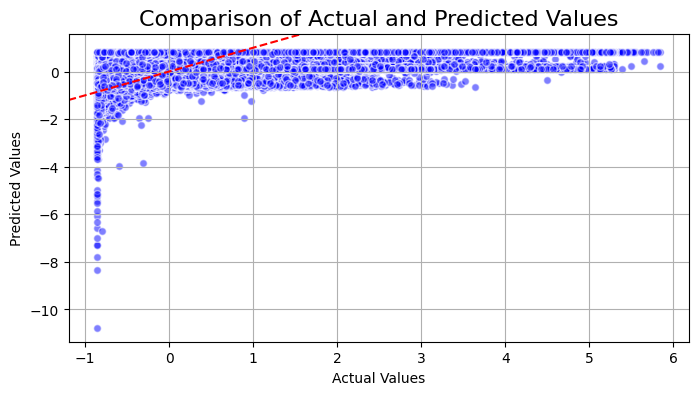

In [217]:
plt.figure(figsize=(8, 4))  # Set the size of the plot
plt.scatter(Y_test, prediction_lr, alpha=0.5, color='blue', edgecolors='w', s=30)
plt.title('Comparison of Actual and Predicted Values', fontsize=16) 
plt.xlabel('Actual Values', fontsize=10)
plt.ylabel('Predicted Values', fontsize=10)  
plt.grid(True) 
plt.axline([0, 0], [1, 1], color='red', linestyle='--')  

plt.show()

In [204]:
# Normalized ridge regression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Create a scaler instance
scaler = StandardScaler()

# Normalize the training data
#X_train_scaled = scaler.fit_transform(X_train)

# Create the Ridge regression model without the 'normalize' parameter
ridge_model = Ridge(alpha=0.05)

# Fit the model with the normalized training data
ridge_model.fit(X_train, Y_train)


Ridge(alpha=0.05)

In [205]:
# Prediction through ridge regression
prediction_ridge = ridge_model.predict(X_test)

In [206]:
intercept_ridge = ridge_model.intercept_
coeff_ridge = ridge_model.coef_
print("Ridge regression train score = ", ridge_model.score(X_train,Y_train))
print("Ridge regression test score = ", ridge_model.score(X_test,Y_test))
print("Intercept = ",intercept_ridge[0])
print("Coefficient of Total Reviews = ",coeff_ridge[0][0])
print("Coefficient of Average Rating = ",coeff_ridge[0][1])
print("Coefficient of Degree Centrality =",coeff_ridge[0][2])
print("Coefficient of Clustering Coefficient =",coeff_ridge[0][3])


Ridge regression train score =  0.2612850162314859
Ridge regression test score =  0.26162487805144374
Intercept =  3.0742453026388545e-17
Coefficient of Total Reviews =  -0.020602008173146426
Coefficient of Average Rating =  -0.2824721934099256
Coefficient of Degree Centrality = -0.17077649965097857
Coefficient of Clustering Coefficient = -0.2303978898678491


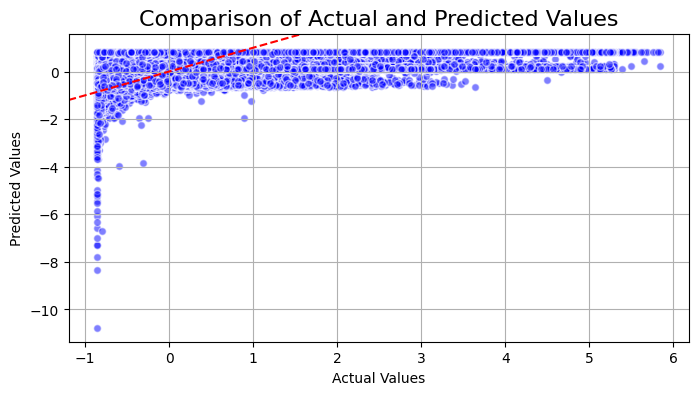

In [216]:
plt.figure(figsize=(8, 4))  # Set the size of the plot
plt.scatter(Y_test, prediction_ridge, alpha=0.5, color='blue', edgecolors='w', s=30)
plt.title('Comparison of Actual and Predicted Values', fontsize=16) 
plt.xlabel('Actual Values', fontsize=10)
plt.ylabel('Predicted Values', fontsize=10)  
plt.grid(True) 
plt.axline([0, 0], [1, 1], color='red', linestyle='--')  

plt.show()

In [209]:
# Lasso regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Create a scaler instance for normalizing the data
#scaler = StandardScaler()

# Normalize the training data
X_train_scaled = scaler.fit_transform(X_train)

# Create the Lasso regression model
lasso_model = Lasso(alpha=0.05)

# Fit the model with the normalized training data
lasso_model.fit(X_train, Y_train)


Lasso(alpha=0.05)

In [210]:
# Prediction with lasso regression
prediction_lasso = lasso_model.predict(X_test)

In [211]:
intercept_lasso = lasso_model.intercept_
coeff_lasso = lasso_model.coef_
print("Lasso regression train score = ", lasso_model.score(X_train,Y_train))
print("Lasso regression test score = ", lasso_model.score(X_test,Y_test))
print("Intercept = ",intercept_lasso)
print("Coefficient of Total Reviews = ",coeff_lasso[0])
print("Coefficient of Average Rating = ",coeff_lasso[1])
print("Coefficient of Degree Centrality =",coeff_lasso[2])
print("Coefficient of Clustering Coefficient =",coeff_lasso[3])

Lasso regression train score =  0.25629753590213356
Lasso regression test score =  0.2565895367102664
Intercept =  [2.12278163e-17]
Coefficient of Total Reviews =  -0.0
Coefficient of Average Rating =  -0.24839572274395502
Coefficient of Degree Centrality = -0.14347276425242297
Coefficient of Clustering Coefficient = -0.20448212216399667


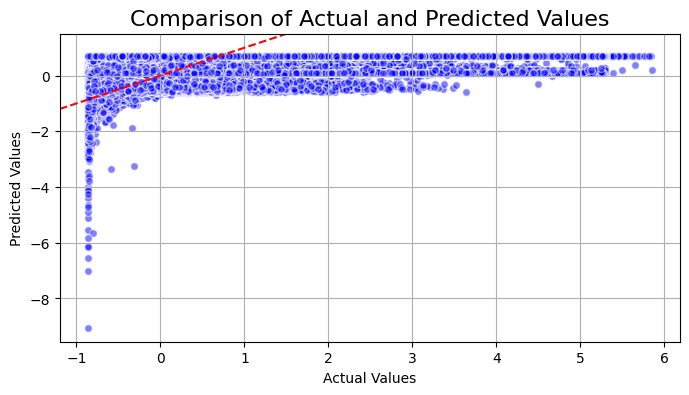

In [215]:
plt.figure(figsize=(8, 4))  # Set the size of the plot
plt.scatter(Y_test, prediction_lasso, alpha=0.5, color='blue', edgecolors='w', s=30)
plt.title('Comparison of Actual and Predicted Values', fontsize=16) 
plt.xlabel('Actual Values', fontsize=10)
plt.ylabel('Predicted Values', fontsize=10)  
plt.grid(True) 
plt.axline([0, 0], [1, 1], color='red', linestyle='--')  

plt.show()

In [220]:
# Removing clustering coefficient and degree centrality from the dataset
X_train_new = X_train[:, [0, 1]]
X_test_new = X_test[:, [0, 1]]

In [221]:
# Normalized linear regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Creating a scaler instance
scaler = StandardScaler()

# Normalizing the training data
X_train_normalized = scaler.fit_transform(X_train_new)

# Creating the Linear Regression model
lr_new = LinearRegression()

# Fitting the model with the normalized training data
lr_new.fit(X_train_normalized, Y_train)

LinearRegression()

In [222]:
prediction_lr_new = lr_new.predict(X_test_new)

In [223]:
intercept_lr_new = lr_new.intercept_
coeff_lr_new = lr_new.coef_
print("Linear regression train score = ", lr_new.score(X_train_new,Y_train))
print("Linear regression test score = ", lr_new.score(X_test_new,Y_test))
print("Intercept = ",intercept_lr_new[0])
print("Coefficient of Total Reviews = ",coeff_lr_new[0][0])
print("Coefficient of Average Rating = ",coeff_lr_new[0][1])


Linear regression train score =  0.15680671055001538
Linear regression test score =  0.15608248324553065
Intercept =  -4.35006734487041e-17
Coefficient of Total Reviews =  -0.058542075061078315
Coefficient of Average Rating =  -0.3862755243162661


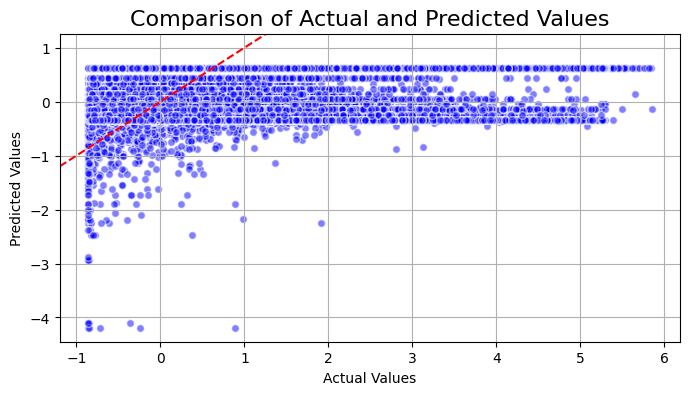

In [224]:
plt.figure(figsize=(8, 4))  # Set the size of the plot
plt.scatter(Y_test, prediction_lr_new, alpha=0.5, color='blue', edgecolors='w', s=30)
plt.title('Comparison of Actual and Predicted Values', fontsize=16) 
plt.xlabel('Actual Values', fontsize=10)
plt.ylabel('Predicted Values', fontsize=10)  
plt.grid(True) 
plt.axline([0, 0], [1, 1], color='red', linestyle='--')  

plt.show()

### Girvan Newman Algorithm

In [84]:
# Transformation of DVD subset into graph
connections_dvd_graph = nx.Graph()
for key, value in amazon_dvd.items():
  connections_dvd_graph.add_node(key)
  for i in value['connections'].split():
    connections_dvd_graph.add_node(i.strip())
    similarity = 0
    try:
      set_1 = set(amazon_dvd[key]['categories'].split())
      set_2 = set(amazon_dvd[i]['categories'].split())
    except KeyError:
      continue
    union = set_1 & set_2
    intersection = set_1 | set_2
    if(len(union)) > 0:
      similarity = round(len(intersection)/len(union),2)
    connections_dvd_graph.add_edge(key, i.strip(), weight=similarity)

In [85]:
# Generator object of communities through Girvan Newman algorithm
communities_dvd = nx.algorithms.community.girvan_newman(connections_dvd_graph)

In [ ]:
# First community
communities_newman = next(communities_dvd)

In [ ]:
# Evaluating the modularity of the algorithm
modularity_newman_new = nx.algorithms.community.modularity(connections_dvd_graph, communities_newman)

In [ ]:
# Finding the optimal modularity, and the count
modularity_newman_old = 0.00001
count = 0
while modularity_newman_new > modularity_newman_old:
  modularity_newman_old = modularity_newman_new
  communities_newman_final = communities_newman
  communities_newman = next(communities)
  modularity_newman_new = nx.algorithms.community.modularity(connections_dvd_graph, communities_newman)
  count +=1